## <center> Trainner Script 
we are using our custom TrafficSignNet 

In [1]:
from traffic_sign_net import TrafficSignNet # custom Sequential model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

We will use scikit-image for preprocessing our dataset in lieu of OpenCV as scikit-image provides some additional preprocessing algorithms that OpenCV does not 

In [2]:
from skimage import transform
from skimage import exposure
from skimage import io

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import os

initialize the list of data and labels

In [4]:
def load_split(basePath, csvPath):
    data = []
    labels = []
    
    #The format of the data is: Width, Height, X1, Y1, X2, Y2, ClassID, Image Path
    rows = open(csvPath).read().strip().split('\n')[1:] # skipping the first header row
    random.shuffle(rows)
    
    #progressBar
    pbar = tqdm(total=len(rows), desc="loaded:")
    for (i, row) in enumerate(rows):
        (label, imagePath) = row.strip().split(",")[-2:]
        
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)
        
        #images by applying CLAHE
        image = transform.resize(image, (32, 32)) #resize
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        
        data.append(image)
        labels.append(int(label))
        
        
        pbar.update(1) #progessBAr
    pbar.close()
        
    
    #convert to numpy
    data = np.array(data)
    labels = np.array(labels)
    
    return (data, labels)

In [5]:
# epochs to train for, base learning rate and batch size
EPOCHS = 30
INIT_LR = 1e-3 # 0.001
BS = 64

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:] #except header
labelNames = [l.split(",")[1] for l in labelNames]
print("numOf Sign Can  be detect ", len(labelNames))

numOf Sign Can  be detect  43


In [6]:
trainPath = r'dataset/Train.csv'
textPath = r'dataset/Test.csv'

print("🔃: loading dataset")
(trainX, trainY) =  load_split("dataset", trainPath) #data , label
(testX, testY) = load_split("dataset", textPath)

🔃: loading dataset


loaded::   0%|          | 0/39209 [00:00<?, ?it/s]

loaded::   0%|          | 0/12630 [00:00<?, ?it/s]

In [13]:
#scale range [0, 1]
trainX = trainX.astype("float32") /255.0
testX = testX.astype("float32") /255.0

In [14]:
print( trainX.shape, trainY.shape, testX.shape, testY.shape)

(39209, 32, 32, 3) (39209,) (12630, 32, 32, 3) (12630,)


In [15]:
#oneHot encode the train & testing labels
numOfLabel = len(np.unique(trainY))
trainY = to_categorical(trainY, numOfLabel)
testY = to_categorical(testY, numOfLabel)

we have significantly more images for some classes than others

In [16]:
# account for skew in the labeled data 
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [17]:
print(len(classTotals),len(classWeight) )

43 43


#### image generator for data augmentation 
 we’re not applying horizontal or vertical flips here as 
traffic signs in the wild will not be flipped.

In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

initialize the optimizer and compile the model

In [19]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / (EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, channel=3, classes=numOfLabel)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## <center> Train the network
In keras, fit() is much similar to sklearn's fit method, where you pass array of features as x values and target as y values. You pass your whole dataset at once in fit method. Also, use it if you can load whole data into your memory (small dataset).

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. As it is written in keras documentation, generator is used when you want to avoid duplicate data when using multiprocessing. This is for practical purpose, when you have large dataset.
    
#### Warning: THIS FUNCTION IS DEPRECATED.    
It will be removed in a future version. Instructions for updating: Please use Model.fit, which supports generators.

In [21]:
print("trainX shape:", trainX.shape, "trainY shape: ", trainY.shape, "\n"
     "testX shape: ", testX.shape, "testY ", testY.shape)

trainX shape: (39209, 32, 32, 3) trainY shape:  (39209, 43) 
testX shape:  (12630, 32, 32, 3) testY  (12630, 43)


In [25]:
import math
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch= trainX.shape[0] // BS,
    epochs=EPOCHS,
#     class_weight=classWeight,
    verbose=1)

Epoch 1/30
612/612 [==============================] - 44s 68ms/step - loss: 3.4254 - accuracy: 0.1895 - val_loss: 2.5293 - val_accuracy: 0.2724
Epoch 2/30
612/612 [==============================] - 41s 67ms/step - loss: 1.4962 - accuracy: 0.5310 - val_loss: 0.7882 - val_accuracy: 0.7245
Epoch 3/30
612/612 [==============================] - 41s 67ms/step - loss: 1.0179 - accuracy: 0.6642 - val_loss: 0.5138 - val_accuracy: 0.8375
Epoch 4/30
612/612 [==============================] - 41s 67ms/step - loss: 0.7342 - accuracy: 0.7634 - val_loss: 0.4479 - val_accuracy: 0.8489
Epoch 5/30
612/612 [==============================] - 42s 68ms/step - loss: 0.5819 - accuracy: 0.8117 - val_loss: 0.5249 - val_accuracy: 0.8386
Epoch 6/30
612/612 [==============================] - 40s 66ms/step - loss: 0.4626 - accuracy: 0.8512 - val_loss: 0.3499 - val_accuracy: 0.8863
Epoch 7/30
612/612 [==============================] - 40s 66ms/step - loss: 0.4059 - accuracy: 0.8677 - val_loss: 0.2895 - val_accuracy:

## having problem with class_weigth

evaluate the network & save the model

In [26]:
predictions = model.predict(testX, batch_size=BS)
print(classification_report(
    testY.argmax(axis=1),
    predictions.argmax(axis=1),
    target_names=labelNames))

# save the network to disk
print("[INFO] serializing network to ")
model.save(r'output/modelWithoutWeigth.model', save_format="h5")

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.68      0.72      0.70        60
                              Speed limit (30km/h)       0.71      0.97      0.82       720
                              Speed limit (50km/h)       0.83      0.80      0.81       750
                              Speed limit (60km/h)       0.95      0.35      0.52       450
                              Speed limit (70km/h)       0.96      0.54      0.69       660
                              Speed limit (80km/h)       0.69      0.84      0.76       630
                       End of speed limit (80km/h)       0.63      0.75      0.68       150
                             Speed limit (100km/h)       0.66      0.79      0.72       450
                             Speed limit (120km/h)       0.88      0.50      0.64       450
                                        No passing       1.00      0.54      0.

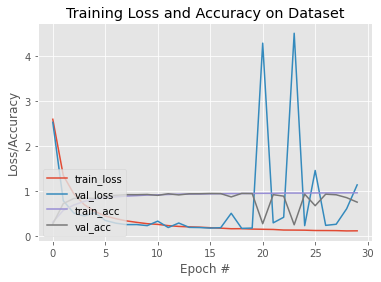

In [27]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(r'output/resultWithoutWeigth.png')